## Análise dos dados do INMET e treinamento de Modelo pra previsão de temperatura

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import joblib


# 1. Carregar o CSV, pulando as 10 linhas iniciais
caminho_csv = '/home/iioulos/Documents/IC_Danilo-Cotozika/Dados do INEP que eu solicitei/dados_A707_D_2014-01-01_2025-05-01.csv'

# Pula as 10 primeiras linhas que são metadados e usa a 11ª como cabeçalho
df = pd.read_csv(caminho_csv, sep=',', encoding='latin1', skiprows=10)

# Lê pulando as 10 linhas e mostra o resultado bruto
df_debug = pd.read_csv(caminho_csv, sep=',', encoding='latin1', skiprows=10)

df_debug.columns
df_debug.head()

,Data Medicao,PRECIPITACAO TOTAL,DIARIO (AUT)(mm),PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB),TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(Â°C),TEMPERATURA MAXIMA,DIARIA (AUT)(Â°C),TEMPERATURA MEDIA,DIARIA (AUT)(Â°C).1,TEMPERATURA MINIMA,DIARIA (AUT)(Â°C).2
0,2014-01-01,5.0,960.7,21.8,32.3,26.0,23.1,78.8,47.0,10.5,1.0
1,2014-01-02,9.2,959.4,21.4,33.9,26.0,22.2,76.7,45.0,10.8,1.6
2,2014-01-03,3.6,960.3,21.1,32.9,26.6,24.1,72.4,46.0,13.4,0.9
3,2014-01-04,6.4,962.9,20.3,34.4,27.0,22.6,68.5,36.0,13.3,1.2
4,2014-01-05,0.6,964.2,19.9,31.2,25.6,21.6,71.5,45.0,9.4,1.9


In [2]:
colunas = [
    'data', 'precipitacao_total', 'pressao_atm_media', 
    'temp_orvalho_media', 'temp_maxima', 'temp_media', 
    'temp_minima', 'umidade_relativa_media', 
    'umidade_relativa_minima', 'umidade_relativa_maxima', 
    'vento_vel_media'
]

df = pd.read_csv(
    caminho_csv,
    sep=',', 
    encoding='latin1',
    skiprows=11,    # também to pulando a linha de cabeçalho textual
    header=None,    # Não tenta usar cabeçalho do arquivo
    names=colunas   # Usa os nomes definidos acima
)

df

,data,precipitacao_total,pressao_atm_media,temp_orvalho_media,temp_maxima,temp_media,temp_minima,umidade_relativa_media,umidade_relativa_minima,umidade_relativa_maxima,vento_vel_media
0,2014-01-01,5.0,960.7,21.8,32.3,26.0,23.1,78.8,47.0,10.5,1.0
1,2014-01-02,9.2,959.4,21.4,33.9,26.0,22.2,76.7,45.0,10.8,1.6
2,2014-01-03,3.6,960.3,21.1,32.9,26.6,24.1,72.4,46.0,13.4,0.9
3,2014-01-04,6.4,962.9,20.3,34.4,27.0,22.6,68.5,36.0,13.3,1.2
4,2014-01-05,0.6,964.2,19.9,31.2,25.6,21.6,71.5,45.0,9.4,1.9
...,...,...,...,...,...,...,...,...,...,...,...
4134,2025-04-27,NaN,NaN,NaN,NaN,NaN,21.4,87.7,56.0,7.7,NaN
4135,2025-04-28,NaN,NaN,NaN,26.1,NaN,18.9,90.5,67.0,11.8,NaN
4136,2025-04-29,NaN,NaN,NaN,NaN,NaN,NaN,65.1,42.0,4.1,NaN
4137,2025-04-30,0.0,964.6,15.4,27.4,20.7,16.4,73.9,45.0,8.4,1.5


In [3]:
df.isna().sum()

data                         0
precipitacao_total         451
pressao_atm_media          138
temp_orvalho_media         444
temp_maxima                127
temp_media                 174
temp_minima                124
umidade_relativa_media     184
umidade_relativa_minima     30
umidade_relativa_maxima     70
vento_vel_media            140
dtype: int64

### Interpolando valores numéricos

In [4]:
# usando a coluna 'data' (em datetime) como índice
df["data"] = pd.to_datetime(df["data"])
df_interp = df.copy()
df_interp.set_index("data", inplace=True)

# interpolando com o índice temporal (com base nas datas)
df_interp = df_interp.interpolate(method="time")

# Resetando o índice para voltar à estrutura original
df_interp = df_interp.reset_index()


### Visualização de Séries temporais

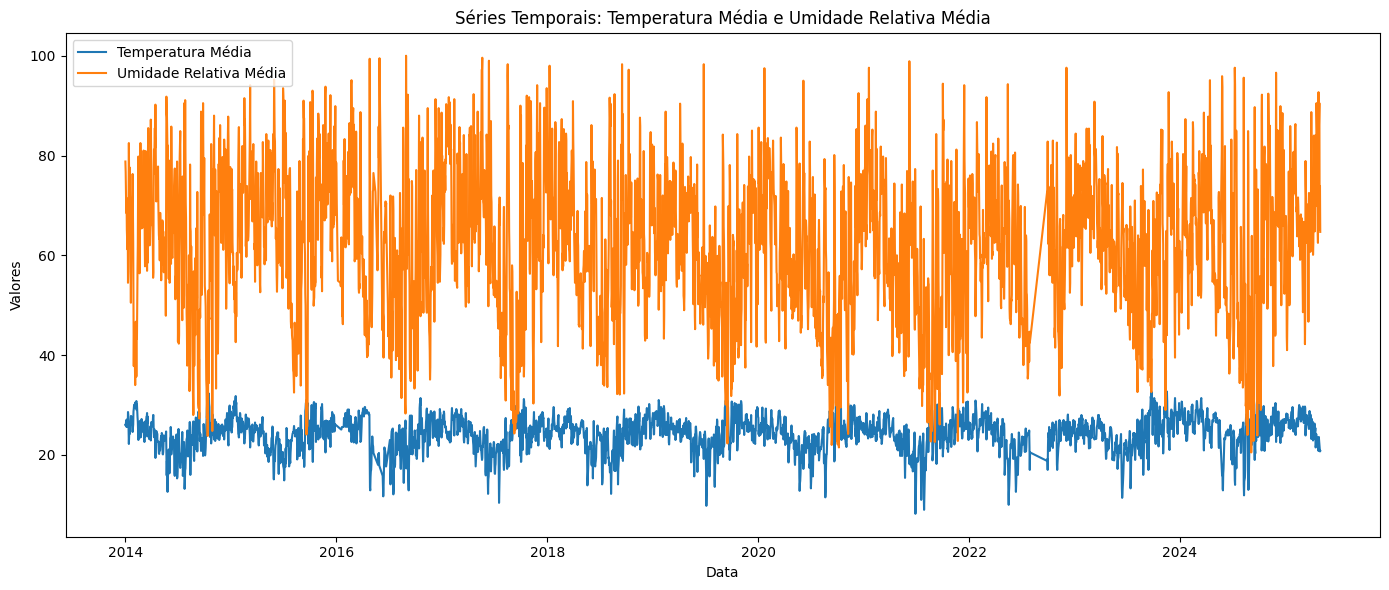

In [5]:
# Importando matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_interp["data"], df_interp["temp_media"], label="Temperatura Média")
plt.plot(df_interp["data"], df_interp["umidade_relativa_media"], label="Umidade Relativa Média")

plt.xlabel("Data")
plt.ylabel("Valores")
plt.title("Séries Temporais: Temperatura Média e Umidade Relativa Média")
plt.legend()
plt.tight_layout()
plt.show()


### Análisando a correlação

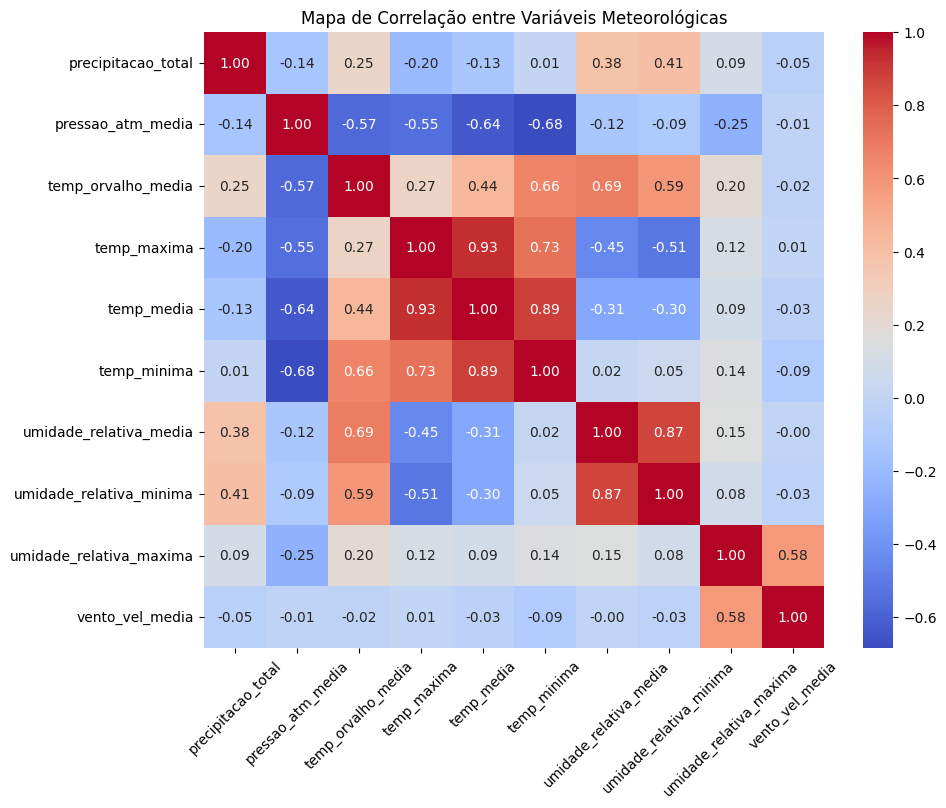

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_interp.drop(columns="data").corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation=45)
plt.title("Mapa de Correlação entre Variáveis Meteorológicas")
plt.show()

### Modelo de Regressão - prevendo temp_media (sem lags)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Dicionário para armazenar os resultados dos modelos
results = {}

# Seleção de features e target
features = ["temp_minima", "temp_maxima", "umidade_relativa_media", "pressao_atm_media"]
df_model = df_interp.dropna(subset=features + ["temp_media"])  # garantindo que não tem NaN

X = df_model[features]
y = df_model["temp_media"]

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Prevendo e avaliando
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
results['Linear Regression'] = {'RMSE': round(rmse, 2), 'R2': round(r2, 2)}
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")


RMSE: 0.66
R²: 0.96


→ Em média, o erro das previsões do modelo é de 0.66 unidades (no caso graus Celsius).
~ quanto menor o valor do erro, melhor.

→ 96% da variação da temperatura média pode ser explicada pelas variáveis fornecidas. isso é bom pq mostra que o modelo está com um desempenho top usando o conjunto de dados.

### Plotando Previsões vs Reais

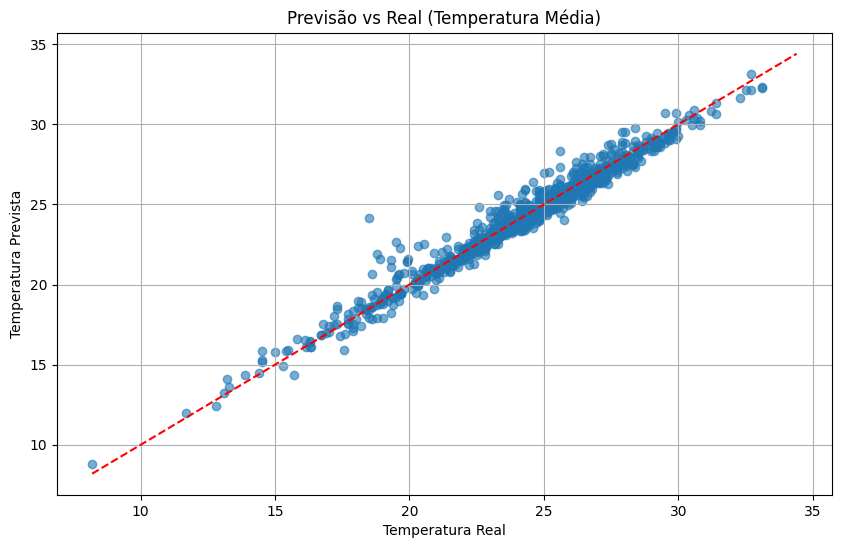

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Temperatura Real")
plt.ylabel("Temperatura Prevista")
plt.title("Previsão vs Real (Temperatura Média)")
plt.grid(True)
plt.show()

A maioria dos pontos está bem perto da linha vermelha, o que faz sentido pelo valor R² = 0.96.

Poucos outliers visíveis: não tem muitos pontos muito distantes da linha, ou seja, os erros não estão variando muito.

O modelo parece estar generalizando bem pros dados de teste.

# Incluindo Lag Features

In [9]:
df = pd.read_csv(caminho_csv, sep=',', encoding="latin1", skiprows=11, header=None, names=colunas)
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.interpolate(method='time')
df = df.reset_index()

# Variável alvo
target_variable = 'temp_media'

# Colunas para criar lag features
columns_to_lag = ['temp_media', 'temp_minima', 'temp_maxima', 'umidade_relativa_media', 'pressao_atm_media']

# Definir os lags a serem criados
lags = [1, 2, 3, 7] # Lags de 1, 2, 3 dias e 1 semana

df_with_lags = df.copy()

print(f"Criando lag features para as colunas: {columns_to_lag} com lags: {lags}")
for col in columns_to_lag:
    for lag in lags:
        df_with_lags[f'{col}_lag{lag}'] = df_with_lags[col].shift(lag)

# Removendo as linhas com NaN resultantes da criação de lags
initial_rows = df_with_lags.shape[0]
df_with_lags.dropna(inplace=True)
final_rows = df_with_lags.shape[0]
print(f"Removidas {initial_rows - final_rows} linhas devido a NaNs das lag features.")

# Salvando o dataframe com lag features (opcional no notebook, mas útil para persistência)
path_df_lags = "/home/iioulos/Documents/IC_Danilo-Cotozika/dados_climaticos_com_lags.csv"
df_with_lags.to_csv(path_df_lags, index=False)
print(f"Dataframe com lag features salvo em: {path_df_lags}")

Criando lag features para as colunas: ['temp_media', 'temp_minima', 'temp_maxima', 'umidade_relativa_media', 'pressao_atm_media'] com lags: [1, 2, 3, 7]
Removidas 7 linhas devido a NaNs das lag features.
Dataframe com lag features salvo em: /home/iioulos/Documents/IC_Danilo-Cotozika/dados_climaticos_com_lags.csv


Heatmap de correlação salvo em: /home/iioulos/Documents/IC_Danilo-Cotozika/correlacao_lag_features.png


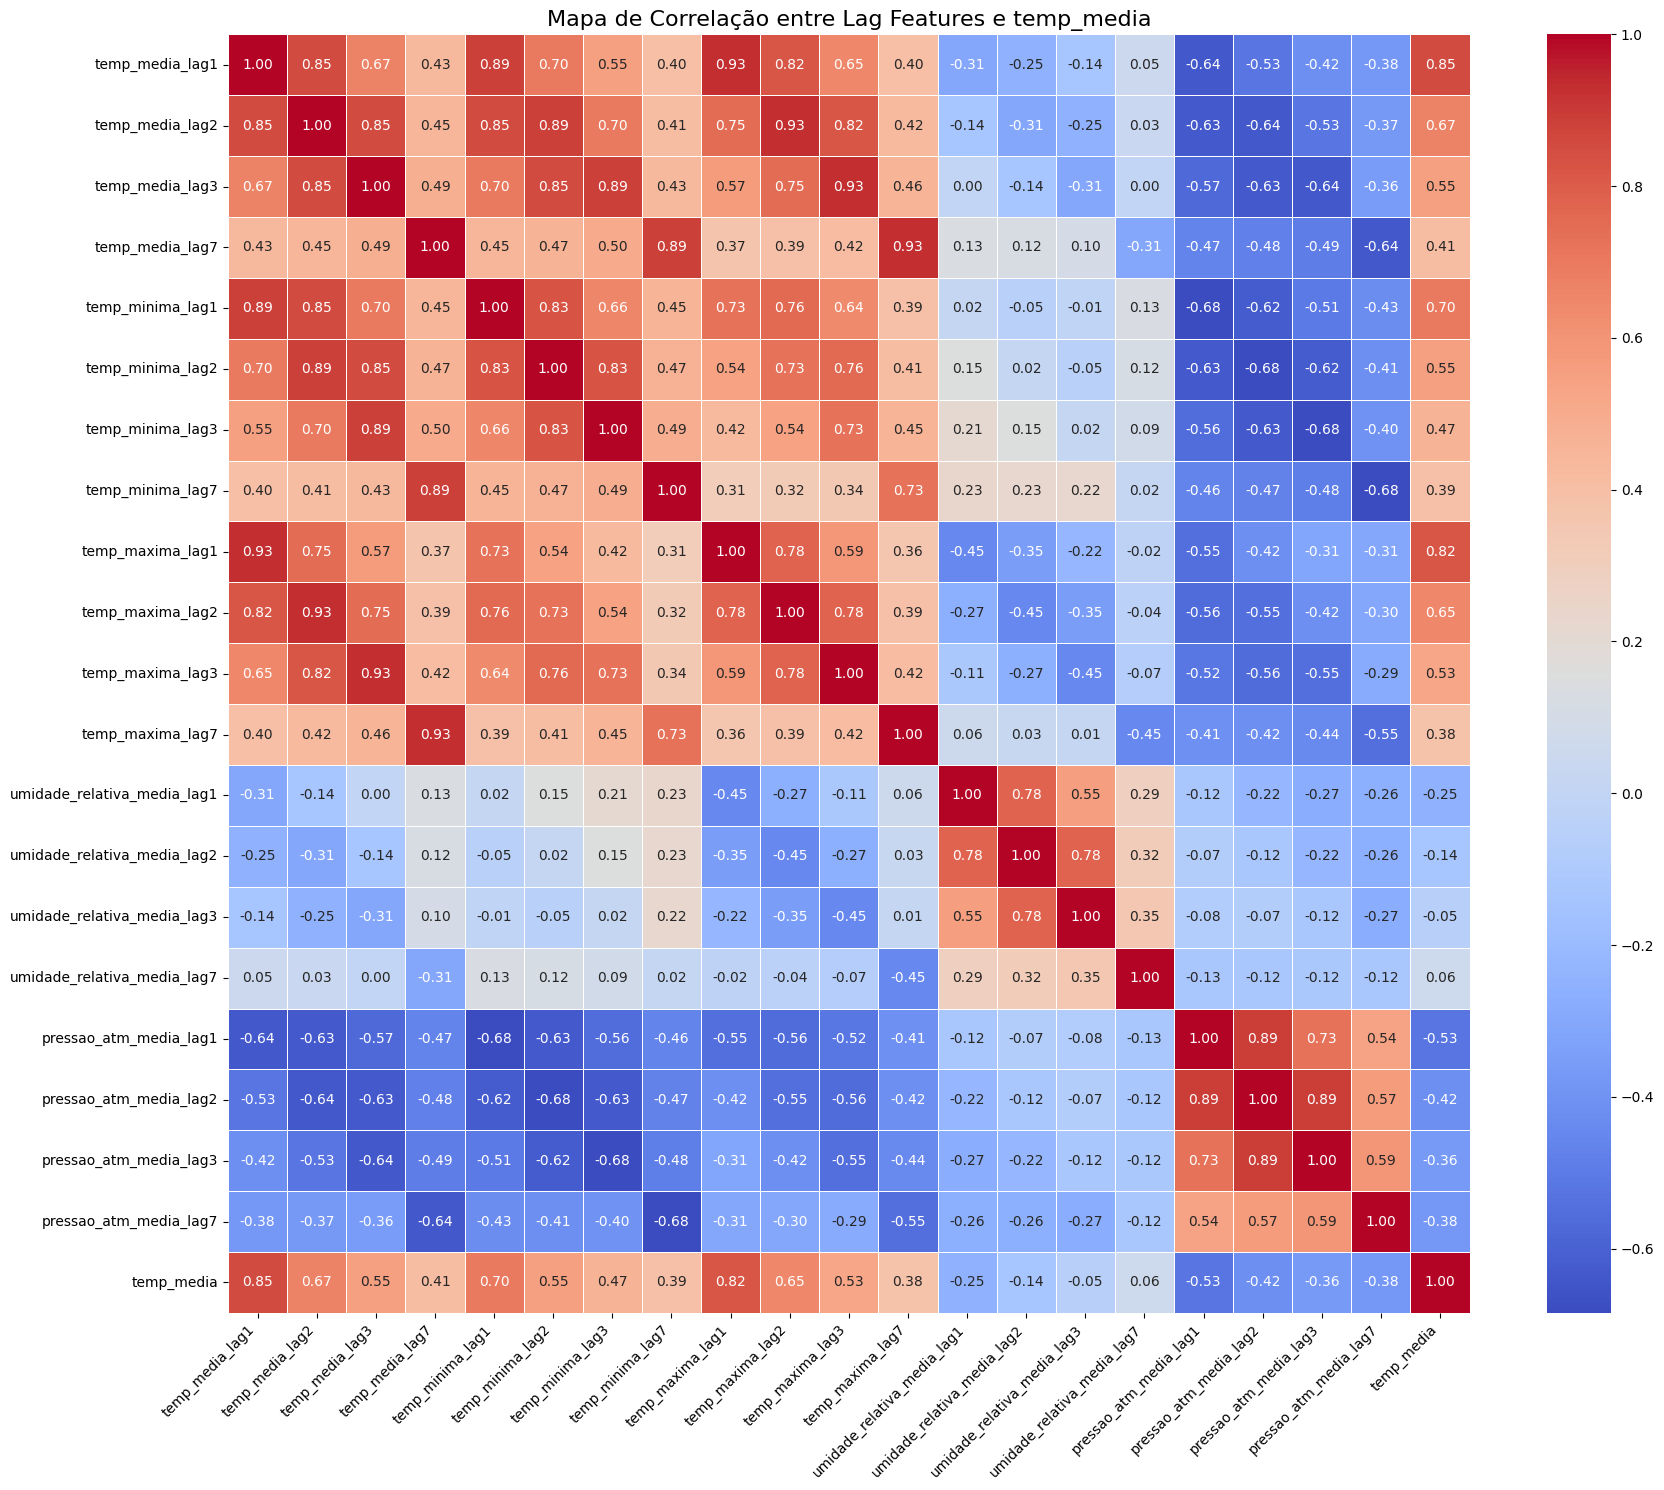

temp_media                     1.000000
temp_media_lag1                0.850526
temp_maxima_lag1               0.816804
temp_minima_lag1               0.699297
temp_media_lag2                0.667489
temp_maxima_lag2               0.645324
temp_minima_lag2               0.550696
temp_media_lag3                0.549222
temp_maxima_lag3               0.526136
temp_minima_lag3               0.465674
temp_media_lag7                0.414218
temp_minima_lag7               0.390312
temp_maxima_lag7               0.375009
umidade_relativa_media_lag7    0.063976
umidade_relativa_media_lag3   -0.054397
umidade_relativa_media_lag2   -0.138252
umidade_relativa_media_lag1   -0.248468
pressao_atm_media_lag3        -0.362812
pressao_atm_media_lag7        -0.381166
pressao_atm_media_lag2        -0.416449
pressao_atm_media_lag1        -0.525391
Name: temp_media, dtype: float64

In [10]:
# Visualizar correlações
lag_feature_columns = [col for col in df_with_lags.columns if '_lag' in col]
columns_for_heatmap = lag_feature_columns + [target_variable]
correlation_matrix = df_with_lags[columns_for_heatmap].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title(f'Mapa de Correlação entre Lag Features e {target_variable}', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
path_heatmap_lags = "/home/iioulos/Documents/IC_Danilo-Cotozika/correlacao_lag_features.png" # Caminho para salvar a imagem
plt.savefig(path_heatmap_lags)
print(f"Heatmap de correlação salvo em: {path_heatmap_lags}")
plt.show()

# Exibir as primeiras 5 linhas do dataframe com lag features
df_with_lags.head()

# Exibir a correlação das lag features com a variável alvo 'temp_media'
correlation_matrix[target_variable].sort_values(ascending=False)


In [11]:
print("\nTreinando e avaliando: Regressão Linear com Lag Features")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
results['Linear Regression (com Lags)'] = {'RMSE': rmse_lr, 'R2': r2_lr}
print(f"  RMSE: {rmse_lr:.4f}")
print(f"  R²: {r2_lr:.4f}")
joblib.dump(lr_model, '/home/iioulos/Documents/IC_Danilo-Cotozika/linear_regression_lags_model.joblib')
print("  Modelo Regressão Linear salvo em /home/ubuntu/linear_regression_lags_model.joblib")


Treinando e avaliando: Regressão Linear com Lag Features
  RMSE: 0.6580
  R²: 0.9644
  Modelo Regressão Linear salvo em /home/ubuntu/linear_regression_lags_model.joblib


## Random Forest

In [12]:
# Carregar o dataframe com lag features
# (Este bloco pode ser adaptado se o df já estiver carregado de uma célula anterior no notebook)
df_lags_path = "/home/iioulos/Documents/IC_Danilo-Cotozika/dados_climaticos_com_lags.csv"
df = pd.read_csv(df_lags_path)

print(f"Dataframe carregado de {df_lags_path} com {df.shape[0]} linhas e {df.shape[1]} colunas.")
# Para exibir o shape no Jupyter, você pode ter uma célula com:
# df.shape

# Definir features (X) e target (y)
if 'data' in df.columns:
    X = df.drop(columns=['data', 'temp_media'])
else:
    X = df.drop(columns=['temp_media'])
y = df['temp_media']

print(f"Features (X) selecionadas: {list(X.columns)}")
# Para exibir as colunas no Jupyter:
# X.columns
print(f"Variável alvo (y): temp_media")

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dados divididos em treino ({X_train.shape[0]} amostras) e teste ({X_test.shape[0]} amostras).")
# Para exibir os shapes no Jupyter:
# X_train.shape, X_test.shape

# --- Modelo 2: Random Forest Regressor ---
print("\nTreinando e avaliando: Random Forest Regressor")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
results['Random Forest Regressor'] = {'RMSE': rmse_rf, 'R2': r2_rf}
print(f"  RMSE: {rmse_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
joblib.dump(rf_model, '/home/iioulos/Documents/IC_Danilo-Cotozika/random_forest_model.joblib')
print("  Modelo Random Forest salvo em /home/ubuntu/random_forest_model.joblib")

Dataframe carregado de /home/iioulos/Documents/IC_Danilo-Cotozika/dados_climaticos_com_lags.csv com 4132 linhas e 31 colunas.
Features (X) selecionadas: ['precipitacao_total', 'pressao_atm_media', 'temp_orvalho_media', 'temp_maxima', 'temp_minima', 'umidade_relativa_media', 'umidade_relativa_minima', 'umidade_relativa_maxima', 'vento_vel_media', 'temp_media_lag1', 'temp_media_lag2', 'temp_media_lag3', 'temp_media_lag7', 'temp_minima_lag1', 'temp_minima_lag2', 'temp_minima_lag3', 'temp_minima_lag7', 'temp_maxima_lag1', 'temp_maxima_lag2', 'temp_maxima_lag3', 'temp_maxima_lag7', 'umidade_relativa_media_lag1', 'umidade_relativa_media_lag2', 'umidade_relativa_media_lag3', 'umidade_relativa_media_lag7', 'pressao_atm_media_lag1', 'pressao_atm_media_lag2', 'pressao_atm_media_lag3', 'pressao_atm_media_lag7']
Variável alvo (y): temp_media
Dados divididos em treino (3305 amostras) e teste (827 amostras).

Treinando e avaliando: Random Forest Regressor
  RMSE: 0.5703
  R²: 0.9705
  Modelo Random 

## Gradient Boosting regressor

In [13]:
print("\nTreinando e avaliando: Gradient Boosting Regressor")
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)
results['Gradient Boosting Regressor'] = {'RMSE': rmse_gbr, 'R2': r2_gbr}
print(f"  RMSE: {rmse_gbr:.4f}")
print(f"  R²: {r2_gbr:.4f}")
joblib.dump(gbr_model, '/home/iioulos/Documents/IC_Danilo-Cotozika/gradient_boosting_model.joblib')
print("  Modelo Gradient Boosting salvo em /home/ubuntu/gradient_boosting_model.joblib")


Treinando e avaliando: Gradient Boosting Regressor
  RMSE: 0.5677
  R²: 0.9708
  Modelo Gradient Boosting salvo em /home/ubuntu/gradient_boosting_model.joblib


## Support Vector Regressor (SVR)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTreinando e avaliando: Support Vector Regressor (SVR)")
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)
results['Support Vector Regressor'] = {'RMSE': rmse_svr, 'R2': r2_svr}
print(f"  RMSE: {rmse_svr:.4f}")
print(f"  R²: {r2_svr:.4f}")
joblib.dump(svr_model, '/home/iioulos/Documents/IC_Danilo-Cotozika/svr_model.joblib')
joblib.dump(scaler, '/home/iioulos/Documents/IC_Danilo-Cotozika/svr_scaler.joblib')
print("  Modelo SVR e Scaler salvos em /home/iioulos/Documents/IC_Danilo-Cotozika/.joblib e /home/iioulos/Documents/IC_Danilo-Cotozika/svr_scaler.joblib")


Treinando e avaliando: Support Vector Regressor (SVR)
  RMSE: 0.5992
  R²: 0.9675
  Modelo SVR e Scaler salvos em /home/iioulos/Documents/IC_Danilo-Cotozika/.joblib e /home/iioulos/Documents/IC_Danilo-Cotozika/svr_scaler.joblib


In [ ]:
# CORREÇÃO: Adicionar import do joblib para salvar o modelo
import joblib

# Agora você pode salvar os modelos corretamente
# Exemplo: salvar o Random Forest
joblib.dump(rf_model, '/home/iioulos/Documents/IC_Danilo-Cotozika/random_forest_model.joblib')
print("Modelo Random Forest salvo com sucesso!")

# Para carregar o modelo mais tarde:
# modelo_carregado = joblib.load('/home/iioulos/Documents/IC_Danilo-Cotozika/random_forest_model.joblib')

## Resultados

In [15]:
# Resultados consolidados dos modelos
results_df = pd.DataFrame(results).T

# No Jupyter, para exibir o DataFrame de resultados:
# results_df

# Salvar os resultados (opcional no notebook, mas útil para persistência)
results_df.to_csv("/home/iioulos/Documents/IC_Danilo-Cotozika/model_comparison_results.csv")
print("\nResultados salvos em /home/iioulos/Documents/IC_Danilo-Cotozika/model_comparison_results.csv")
results_df


Resultados salvos em /home/iioulos/Documents/IC_Danilo-Cotozika/model_comparison_results.csv


,RMSE,R2
Linear Regression,0.660000,0.960000
Linear Regression (com Lags),0.658013,0.964359
Random Forest Regressor,0.570342,0.970541
Gradient Boosting Regressor,0.567690,0.970815
Support Vector Regressor,0.599200,0.967485
